In [1]:
from Transformer import *
from RNN import *
from train_utils import *

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load the entire dataset
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# For subject 1
subject1_indices_train = np.where(person_train_valid == 1)[0]
subject1_indices_test = np.where(person_test == 1)[0]
X_train_valid1 = X_train_valid[subject1_indices_train]
y_train_valid1 = y_train_valid[subject1_indices_train]
X_test1 = X_test[subject1_indices_test]
y_test1 = y_test[subject1_indices_test]

# For all subject
dataset, X_val, y_val, X_test, y_test = process_data(X_train_valid, 
                                                     y_train_valid, 
                                                     X_test, 
                                                     y_test)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

# For subject 1
dataset1, X_val1, y_val1, X_test1, y_test1 = process_data(X_train_valid1, 
                                                          y_train_valid1,
                                                          X_test1, 
                                                          y_test1)
dataloader1 = DataLoader(dataset1, batch_size=100, shuffle=True, drop_last=True)

#### Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

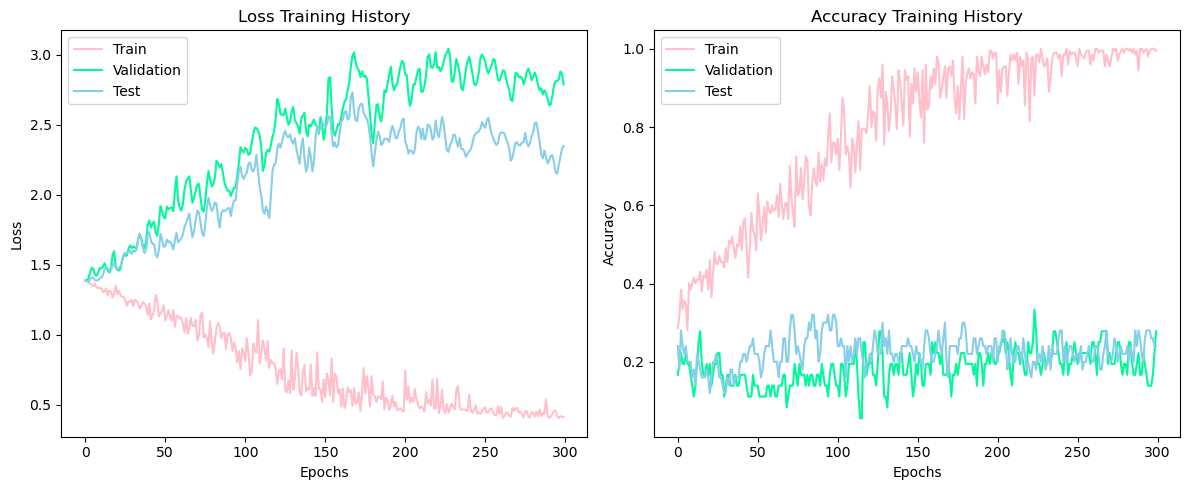

Best test accuracy for RNN is  0.32


In [2]:
rnn_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':True}
rnn = RNN(rnn_config)
rnn_optimizer = optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            rnn, 
                                                                            rnn_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for RNN is ", max(test_acc))

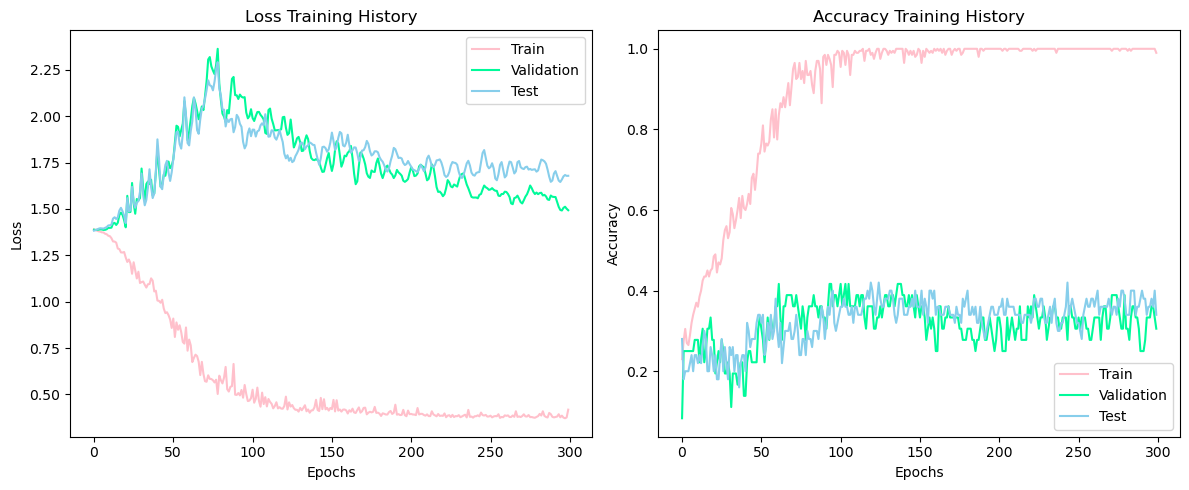

Best test accuracy for LSTM is  0.42


In [3]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for LSTM is ", max(test_acc))

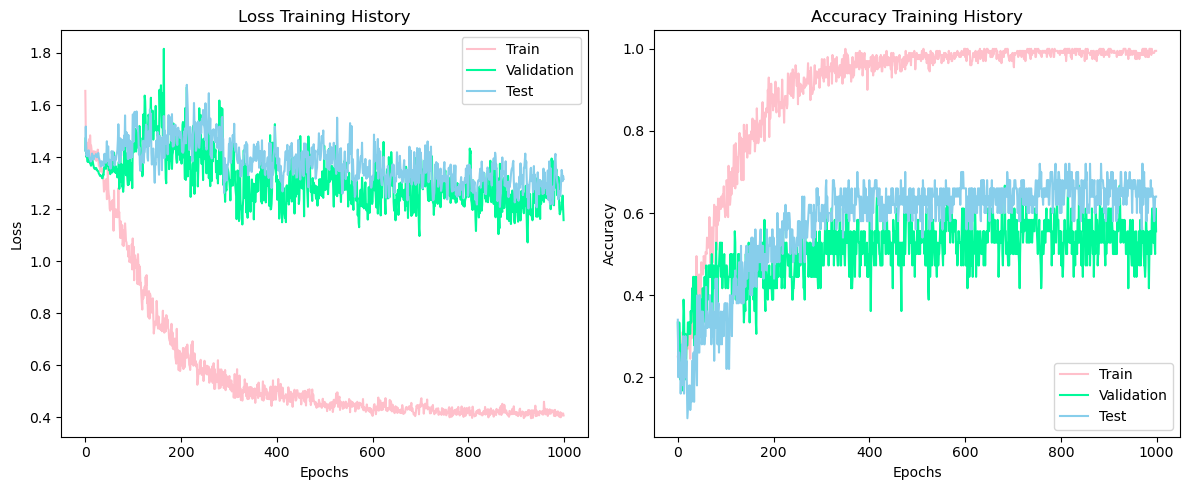

Best test accuracy for Transformer is  0.72


In [5]:
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(1000, 
                                                                            transformer, 
                                                                            transformer_optimizer, 
                                                                            dataloader1, 
                                                                            X_val1, y_val1, 
                                                                            X_test1, y_test1, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for Transformer is ", max(test_acc))

#### Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

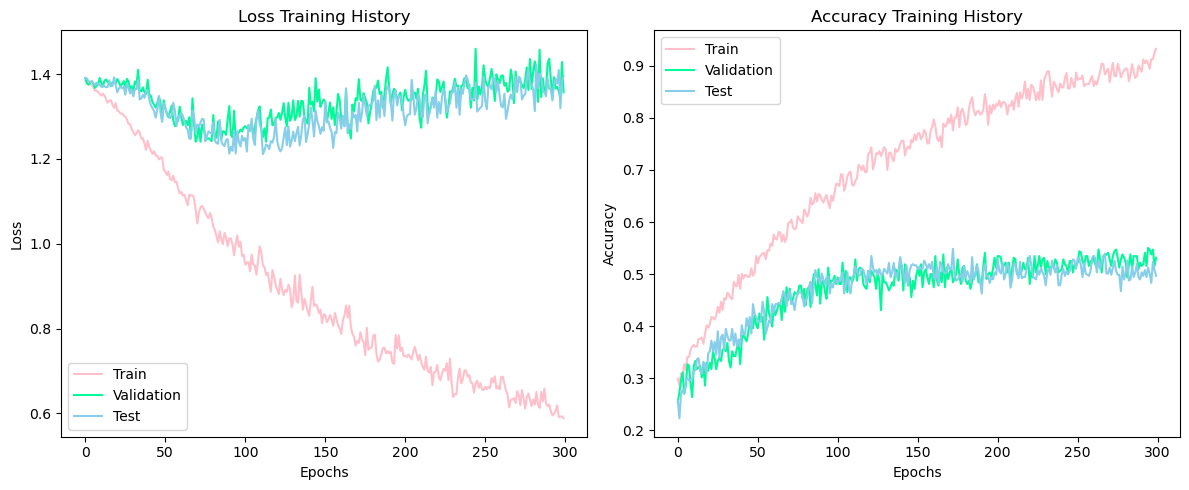

Best test accuracy for RNN is  0.5485327313769752


In [6]:
rnn_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':False,
            'use_attention':True}
rnn = RNN(rnn_config)
rnn_optimizer = optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            rnn, 
                                                                            rnn_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for RNN is ", max(test_acc))

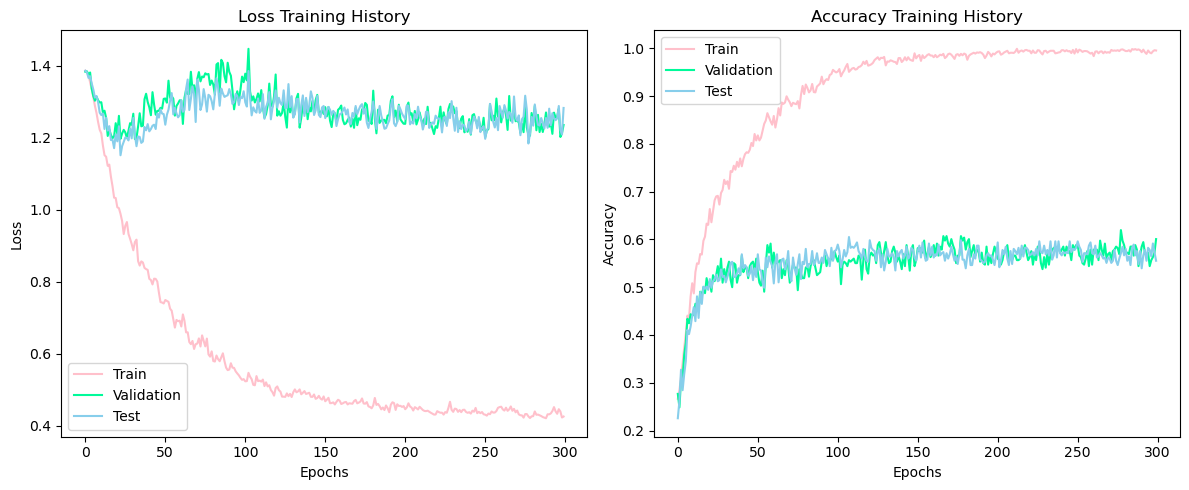

Best test accuracy for LSTM is  0.6049661399548533


In [7]:
lstm_config = {'hidden_size':64, 
            'nhead':8,
            'dropout':0.2, 
            'use_lstm':True,
            'use_attention':True}
lstm = RNN(lstm_config)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(300, 
                                                                            lstm, 
                                                                            lstm_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for LSTM is ", max(test_acc))

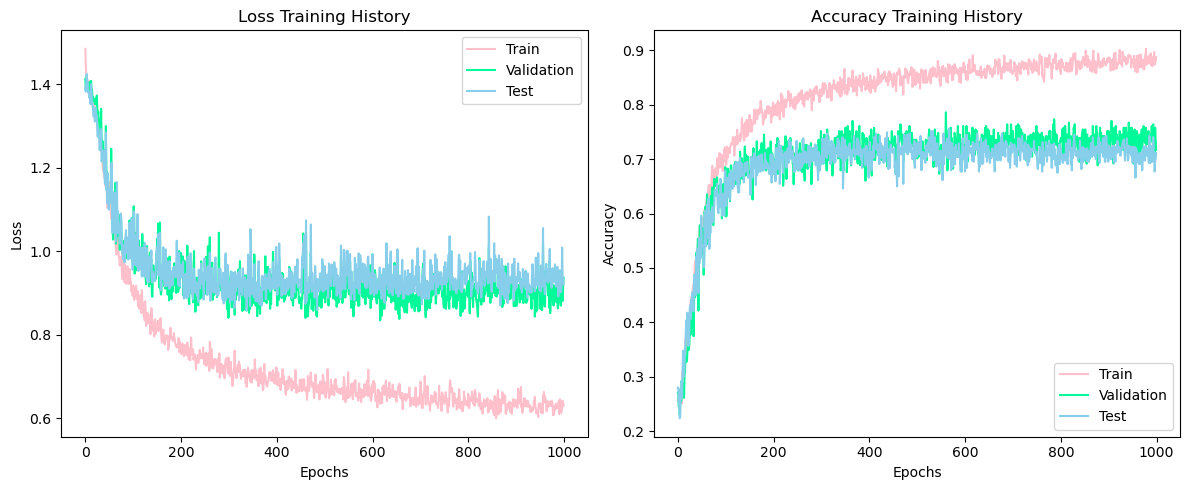

Best test accuracy for Transformer is  0.7562076749435666


In [8]:
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(1000, 
                                                                            transformer, 
                                                                            transformer_optimizer, 
                                                                            dataloader, 
                                                                            X_val, y_val, 
                                                                            X_test, y_test, 
                                                                            600, mute=True)
plot_history(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print("Best test accuracy for Transformer is ", max(test_acc))

#### Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? how much time is required to get a reasonable classification accuracy?)

In [ ]:
seq_len = [100, 200, 300, 400, 500, 600, 700, 800, 900]
history = []
for l in seq_len:
    t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
    transformer = Transformer(t_config)
    transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(1000, 
                                                                                transformer, 
                                                                                transformer_optimizer, 
                                                                                dataloader, 
                                                                                X_val, y_val, 
                                                                                X_test, y_test, 
                                                                                l, mute=True)
    history.append(test_acc)

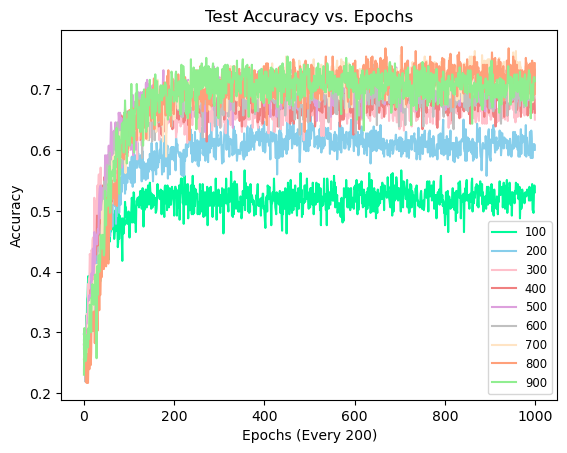

In [19]:
history = np.loadtxt('history.csv', delimiter=',',  dtype=None)
colors = ['mediumspringgreen', 'skyblue', 'pink', 'lightcoral', 'plum', 'silver', 'bisque', 'lightsalmon', 'lightgreen']
for i in range(len(seq_len)):
    h = np.array(history[i])
    #h = h.reshape(-1, 10)
    #h = np.mean(h, axis=1)
    plt.plot(h, label=seq_len[i], color=colors[i])
plt.title("Test Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize='small')
plt.show()